<a id="content"></a>
## Оглавление
- [Перейти к Введению](#intro)
- [Часть 1](#part1)
- [Часть 2](#part2)
- [Часть 3](#part3)
- [Часть 3.5](#part3_5)
- [Часть 4](#part4)

<a id="intro"></a>
## Введение
В задании вы будете работать с тестовыми данными по банкоматам и API ЦБ РФ для получения ключевой ставки.

---
### Специфика данных fees
`fees` — тарифы за обслуживание банкомата инкассаторами. Так как банкоматы могут находиться в разных регионах, тарифы у них могут отличаться.

- **CashDeliveryFixedFee** — фиксированная стоимость доставки наличных (не зависит от суммы).
- **CashDeliveryPercentageFee** — процент от суммы доставленных наличных. Он добавляется к фиксированной стоимости. Если в таблице указано `0.0001`, это значит 0.01% от суммы.
- **CashDeliveryMinFee** — минимальная сумма, которую с нас возьмут по `CashDeliveryPercentageFee`. Например, если мы попросим инкассаторов в ATM_4 довезти всего 10 000 рублей, то с нас возьмут 5250 рублей (фиксированная стоимость), а так как `10 000 * 0.04% < 450 рублей`, то дополнительно возьмут ещё 450 рублей. Итог: 5250 + 450 рублей.

**CashCollection** — это пример сложного тарифа, который учитывает специфику работы с банкоматом. В банкомат деньги не докладывают, а меняют сразу кассету. Есть провайдеры, которые тарифицируют не только доставку, но и пересчёт денег в извлечённой кассете. Например, в ATM_4 у нас именно такой тариф.  
Пример: у нас в банкомате осталось 500 тыс. рублей, а мы хотим, чтобы у него был баланс 2 млн. Тогда мы заказываем довезти кассету на 2 млн. и платим по тарифу за доставку. При доставке старая кассета извлекается, и мы также по тарифу платим за пересчёт 500 тыс. рублей (0.45%, но не менее 1140 рублей).

- **CashCollectionFixedFee** — фиксированная стоимость за извлечение старой кассеты (в данных примерах нулевая).
- **CashCollectionPercentageFee** — процент от суммы извлечённой кассеты.
- **CashCollectionMinFee** — минимальная сумма, которую с нас возьмут по `CashCollectionPercentageFee`.

---

### Специфика данных transactions
Таблица содержит данные по снятиям, пополнениям (инкассациям) и балансу банкомата на конец дня.  
Считаем, что банкоматы в начале года пустые и не работали, поэтому баланс на конец дня равен 0, пока не случится первая инкассация.

- **bal_end_of_day** — баланс на конец дня.
- **cash_in** — пополнение в результате инкассации.
- **cash_out** — снятие наличных клиентами.

---

In [24]:
import pandas as pd
import requests
# from datetime import datetimethem
# from lxml import etree
import xml.etree.ElementTree as ET

from statsmodels.tsa.stattools import adfuller

In [9]:
# Забираем данные по тарфиам на обслуживание банкоматов
fees = pd.read_parquet('https://storage.yandexcloud.net/norvpublic/fees.parquet', engine='pyarrow')
# статистика операция по дням.
transactions = pd.read_parquet('https://storage.yandexcloud.net/norvpublic/transactions.parquet', engine='pyarrow')

In [7]:
# если сбор данных уже сделан
tmp_transaction = pd.read_csv('new_transactions2.csv')

In [4]:
fees

,ATM_ID,CashDeliveryFixedFee,CashDeliveryPercentageFee,CashDeliveryMinFee,CashCollectionFixedFee,CashCollectionPercentageFee,CashCollectionMinFee
0,ATM_1,1365.0,0.0001,NaN,NaN,NaN,NaN
1,ATM_2,1365.0,0.0001,NaN,NaN,NaN,NaN
2,ATM_4,5250.0,0.0004,450.0,0.0,0.0045,1140.0
3,ATM_3,2250.0,0.0001,675.0,NaN,NaN,NaN


In [5]:
fees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ATM_ID                       4 non-null      string 
 1   CashDeliveryFixedFee         4 non-null      float64
 2   CashDeliveryPercentageFee    4 non-null      float64
 3   CashDeliveryMinFee           2 non-null      float64
 4   CashCollectionFixedFee       1 non-null      float64
 5   CashCollectionPercentageFee  1 non-null      float64
 6   CashCollectionMinFee         1 non-null      float64
dtypes: float64(6), string(1)
memory usage: 356.0 bytes


In [6]:
transactions

,date,ATM_ID,bal_end_of_day,cash_in,cash_out
0,2024-01-12 00:00:00+00:00,ATM_1,0.0,0.0,0.0
1,2024-01-12 00:00:00+00:00,ATM_2,0.0,0.0,0.0
2,2024-01-12 00:00:00+00:00,ATM_3,0.0,0.0,0.0
3,2024-01-12 00:00:00+00:00,ATM_4,0.0,0.0,0.0
4,2024-01-13 00:00:00+00:00,ATM_1,0.0,0.0,0.0
...,...,...,...,...,...
1171,2024-10-30 00:00:00+00:00,ATM_4,747650.0,0.0,1000.0
1172,2024-10-31 00:00:00+00:00,ATM_1,3215500.0,0.0,171600.0
1173,2024-10-31 00:00:00+00:00,ATM_2,4754600.0,0.0,395100.0
1174,2024-10-31 00:00:00+00:00,ATM_3,2277000.0,0.0,1000.0


In [7]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1176 entries, 0 to 1175
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype                  
---  ------          --------------  -----                  
 0   date            1176 non-null   datetime64[ms, Etc/UTC]
 1   ATM_ID          1176 non-null   string                 
 2   bal_end_of_day  1176 non-null   float64                
 3   cash_in         1176 non-null   float64                
 4   cash_out        1176 non-null   float64                
dtypes: datetime64[ms, Etc/UTC](1), float64(3), string(1)
memory usage: 46.1 KB


<a id="part1"></a>
### Часть 1 — упущенный процентный доход

[Вернуться к оглавлению](#content)

Специалисту по ML важно уметь получать данные с различных API и читать документацию. Для расчёта упущенного процентного дохода нужно обратиться к API ЦБ РФ и получить динамику ключевой ставки за 2024 год.

https://www.cbr.ru/DailyInfoWebServ/DailyInfo.asmx?op=KeyRate

Для запроса к API не нужен токен и регистрация. ЦБ РФ для части данных предпочитает использовать SOAP.

Учитывая, что хранить наличные деньги в банкомате — не самое удачное инвестиционное решение, посчитайте упущенный процентный доход для каждого банкомата. Рассчитываем, что банк мог бы вложить эти деньги и получить доход, равный ключевой ставке ЦБ РФ, актуальной на день баланса банкомата. Добавьте к таблице `transactions` столбец с упущенной процентной выгодой.


In [5]:
url = "https://www.cbr.ru/DailyInfoWebServ/DailyInfo.asmx"
headers = {
    "Content-Type": "text/xml; charset=utf-8",
    "SOAPAction": "http://web.cbr.ru/KeyRate"
}
soap_request = '''<?xml version="1.0" encoding="utf-8"?>
<soap:Envelope xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance"
               xmlns:xsd="http://www.w3.org/2001/XMLSchema"
               xmlns:soap="http://schemas.xmlsoap.org/soap/envelope/">
  <soap:Body>
    <KeyRate xmlns="http://web.cbr.ru/">
      <fromDate>2024-01-01</fromDate>
      <ToDate>2024-12-31</ToDate>
    </KeyRate>
  </soap:Body>
</soap:Envelope>'''

In [6]:
response = requests.post(url, data=soap_request, headers=headers)
if response.status_code != 200:
    print(f"Ошибка запроса: {response.status_code}")
else:
    print(response.text)

<?xml version="1.0" encoding="utf-8"?><soap:Envelope xmlns:soap="http://schemas.xmlsoap.org/soap/envelope/" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xmlns:xsd="http://www.w3.org/2001/XMLSchema"><soap:Body><KeyRateResponse xmlns="http://web.cbr.ru/"><KeyRateResult><xs:schema id="KeyRate" xmlns="" xmlns:xs="http://www.w3.org/2001/XMLSchema" xmlns:msdata="urn:schemas-microsoft-com:xml-msdata"><xs:element name="KeyRate" msdata:IsDataSet="true" msdata:UseCurrentLocale="true"><xs:complexType><xs:choice minOccurs="0" maxOccurs="unbounded"><xs:element name="KR"><xs:complexType><xs:sequence><xs:element name="DT" msdata:Caption="Дата" type="xs:dateTime" minOccurs="0" /><xs:element name="Rate" msdata:Caption="Ставка %" type="xs:decimal" minOccurs="0" /></xs:sequence></xs:complexType></xs:element></xs:choice></xs:complexType></xs:element></xs:schema><diffgr:diffgram xmlns:msdata="urn:schemas-microsoft-com:xml-msdata" xmlns:diffgr="urn:schemas-microsoft-com:xml-diffgram-v1"><KeyRate xm

In [ ]:
if response.status_code == 200:
    # Сохранение ответа в файл
    with open("response.xml", "w", encoding="utf-8") as file:
        file.write(response.text)
    print("XML-ответ сохранен в файл 'response.xml'")
else:
    print("Error:", response.status_code)

XML-ответ сохранен в файл 'response.xml'


In [8]:
# Перебор структуры XML
tree = ET.ElementTree(ET.fromstring(response.text))
root = tree.getroot()

In [21]:
namespaces = {
    'soap': 'http://schemas.xmlsoap.org/soap/envelope/',
    'web': 'http://web.cbr.ru/',
    'xsd': 'http://www.w3.org/2001/XMLSchema'
}

parse_dataset = pd.DataFrame(columns=['date', 'rate'])
rates = []
dates = []
# Перебираем все элементы в корне
for elem in root.iter():
    print(f"Тег: {elem.tag}, Атрибуты: {elem.attrib}, Значение: {elem.text}")
    if elem.tag == 'DT':
        dates.append(elem.text)
    if elem.tag == 'Rate':
        rates.append(elem.text)

parse_dataset['date'] = dates
parse_dataset['rate'] = rates
# Например, найти элемент KeyRateResponse
# key_rate_response = root.find('.//web:KeyRateResponse', namespaces)
# if key_rate_response is not None:
#     print("\nKeyRateResponse найден:")
#     for child in key_rate_response:
#         print(f"Тег: {child.tag}, Значение: {child.text}")

# Пример извлечения значений
# key_rate_result = root.find('.//web:KeyRateResult', namespaces)
# if key_rate_result is not None:
#     rate = key_rate_result.find('web:rate', namespaces)
#     if rate is not None:
#         print("\nRate:", rate.text)
#         rates.append(rate.text)

    # currency = key_rate_result.find('web:currency', namespaces)
    # if currency is not None:
    #     print("Currency:", currency.text)

Тег: {http://schemas.xmlsoap.org/soap/envelope/}Envelope, Атрибуты: {}, Значение: None
Тег: {http://schemas.xmlsoap.org/soap/envelope/}Body, Атрибуты: {}, Значение: None
Тег: {http://web.cbr.ru/}KeyRateResponse, Атрибуты: {}, Значение: None
Тег: {http://web.cbr.ru/}KeyRateResult, Атрибуты: {}, Значение: None
Тег: {http://www.w3.org/2001/XMLSchema}schema, Атрибуты: {'id': 'KeyRate'}, Значение: None
Тег: {http://www.w3.org/2001/XMLSchema}element, Атрибуты: {'name': 'KeyRate', '{urn:schemas-microsoft-com:xml-msdata}IsDataSet': 'true', '{urn:schemas-microsoft-com:xml-msdata}UseCurrentLocale': 'true'}, Значение: None
Тег: {http://www.w3.org/2001/XMLSchema}complexType, Атрибуты: {}, Значение: None
Тег: {http://www.w3.org/2001/XMLSchema}choice, Атрибуты: {'minOccurs': '0', 'maxOccurs': 'unbounded'}, Значение: None
Тег: {http://www.w3.org/2001/XMLSchema}element, Атрибуты: {'name': 'KR'}, Значение: None
Тег: {http://www.w3.org/2001/XMLSchema}complexType, Атрибуты: {}, Значение: None
Тег: {http:

In [16]:
parse_dataset['date'].info(), transactions['date'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 256 entries, 0 to 255
Series name: date
Non-Null Count  Dtype 
--------------  ----- 
256 non-null    object
dtypes: object(1)
memory usage: 2.1+ KB
<class 'pandas.core.series.Series'>
RangeIndex: 1176 entries, 0 to 1175
Series name: date
Non-Null Count  Dtype         
--------------  -----         
1176 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 9.3 KB


(None, None)

In [28]:
parse_dataset['date'] = pd.to_datetime(parse_dataset['date']).dt.tz_localize(None)
# tmp['date'] = pd.to_datetime(tmp['date']).dt.date
transactions['date'] = pd.to_datetime(transactions['date'].dt.date)

In [29]:
parse_dataset['date'], transactions['date']

(0     2024-12-30
 1     2024-12-28
 2     2024-12-27
 3     2024-12-26
 4     2024-12-25
          ...    
 251   2024-01-09
 252   2024-01-08
 253   2024-01-05
 254   2024-01-04
 255   2024-01-03
 Name: date, Length: 256, dtype: datetime64[ns],
 0      2024-01-12
 1      2024-01-12
 2      2024-01-12
 3      2024-01-12
 4      2024-01-13
           ...    
 1171   2024-10-30
 1172   2024-10-31
 1173   2024-10-31
 1174   2024-10-31
 1175   2024-10-31
 Name: date, Length: 1176, dtype: datetime64[ns])

In [41]:
parse_dataset[(parse_dataset['date'].dt.month == 1 ) & (parse_dataset['date'].dt.day == 10)]

,date,rate
250,2024-01-10,16.00


In [10]:
tmp_transaction = transactions.merge(parse_dataset, on='date', how='left')

NameError: name 'parse_dataset' is not defined

In [42]:
tmp_transaction

,date,ATM_ID,bal_end_of_day,cash_in,cash_out,rate
0,2024-01-12,ATM_1,0.0,0.0,0.0,16.00
1,2024-01-12,ATM_2,0.0,0.0,0.0,16.00
2,2024-01-12,ATM_3,0.0,0.0,0.0,16.00
3,2024-01-12,ATM_4,0.0,0.0,0.0,16.00
4,2024-01-13,ATM_1,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...
1171,2024-10-30,ATM_4,747650.0,0.0,1000.0,21.00
1172,2024-10-31,ATM_1,3215500.0,0.0,171600.0,21.00
1173,2024-10-31,ATM_2,4754600.0,0.0,395100.0,21.00
1174,2024-10-31,ATM_3,2277000.0,0.0,1000.0,21.00


In [42]:
tmp_transaction.to_csv('new_transactions2.csv', index=False)

<a id="part2"></a>
## Часть 2 - расходы на инкассацию

[Вернуться к оглавлению](#content)

Теперь к данным по банкоматам, кроме упущенного процентного дохода, необходимо добавить столбец расходов на инкассацию. Для простоты считаем, что мы не платим за аренду помещения и страхование, поэтому нам достаточно данных по тарифам на инкассацию (`fees`).

In [43]:
fees

,ATM_ID,CashDeliveryFixedFee,CashDeliveryPercentageFee,CashDeliveryMinFee,CashCollectionFixedFee,CashCollectionPercentageFee,CashCollectionMinFee
0,ATM_1,1365.0,0.0001,NaN,NaN,NaN,NaN
1,ATM_2,1365.0,0.0001,NaN,NaN,NaN,NaN
2,ATM_4,5250.0,0.0004,450.0,0.0,0.0045,1140.0
3,ATM_3,2250.0,0.0001,675.0,NaN,NaN,NaN


In [11]:
transactions_fees = tmp_transaction.merge(fees, on='ATM_ID', how='left')

In [12]:
transactions_fees

,date,ATM_ID,bal_end_of_day,cash_in,cash_out,rate,CashDeliveryFixedFee,CashDeliveryPercentageFee,CashDeliveryMinFee,CashCollectionFixedFee,CashCollectionPercentageFee,CashCollectionMinFee
0,2024-01-12,ATM_1,0.0,0.0,0.0,16.0,1365.0,0.0001,NaN,NaN,NaN,NaN
1,2024-01-12,ATM_2,0.0,0.0,0.0,16.0,1365.0,0.0001,NaN,NaN,NaN,NaN
2,2024-01-12,ATM_3,0.0,0.0,0.0,16.0,2250.0,0.0001,675.0,NaN,NaN,NaN
3,2024-01-12,ATM_4,0.0,0.0,0.0,16.0,5250.0,0.0004,450.0,0.0,0.0045,1140.0
4,2024-01-13,ATM_1,0.0,0.0,0.0,NaN,1365.0,0.0001,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1171,2024-10-30,ATM_4,747650.0,0.0,1000.0,21.0,5250.0,0.0004,450.0,0.0,0.0045,1140.0
1172,2024-10-31,ATM_1,3215500.0,0.0,171600.0,21.0,1365.0,0.0001,NaN,NaN,NaN,NaN
1173,2024-10-31,ATM_2,4754600.0,0.0,395100.0,21.0,1365.0,0.0001,NaN,NaN,NaN,NaN
1174,2024-10-31,ATM_3,2277000.0,0.0,1000.0,21.0,2250.0,0.0001,675.0,NaN,NaN,NaN


<a id="part3"></a>
## Часть 3 - анализ данных

[Вернуться к оглавлению](#content)

Посмотрите на данные о снятиях, инкассациях и балансе. В данных подобраны банкоматы, отличающиеся по характеру использования и частоте инкассаций.  
(Эту операцию вы делаете для себя, чтобы лучше понять специфику.)

In [13]:
transactions_fees.describe()

,bal_end_of_day,cash_in,cash_out,rate,CashDeliveryFixedFee,CashDeliveryPercentageFee,CashDeliveryMinFee,CashCollectionFixedFee,CashCollectionPercentageFee,CashCollectionMinFee
count,1.176000e+03,1.176000e+03,1.176000e+03,824.000000,1176.000000,1176.000000,588.000000,294.0,294.0000,294.0
mean,2.879257e+06,2.758759e+05,2.124446e+05,16.873786,2557.500000,0.000175,562.500000,0.0,0.0045,1140.0
std,1.905111e+06,1.315979e+06,3.188842e+05,1.309315,1596.628935,0.000130,112.595785,0.0,0.0000,0.0
min,0.000000e+00,0.000000e+00,0.000000e+00,16.000000,1365.000000,0.000100,450.000000,0.0,0.0045,1140.0
25%,1.200650e+06,0.000000e+00,0.000000e+00,16.000000,1365.000000,0.000100,450.000000,0.0,0.0045,1140.0
50%,2.575200e+06,0.000000e+00,4.007500e+04,16.000000,1807.500000,0.000100,562.500000,0.0,0.0045,1140.0
75%,4.500625e+06,0.000000e+00,3.263000e+05,18.000000,3000.000000,0.000175,675.000000,0.0,0.0045,1140.0
max,7.119900e+06,7.120000e+06,1.909800e+06,21.000000,5250.000000,0.000400,675.000000,0.0,0.0045,1140.0


In [16]:
def check_nacn(data):  
   for i, name in zip(range(data.shape[1]), data.columns):
      print(f"Counts NaN on {name}: {data.iloc[:, i].isna().sum()} of {data.shape[0]}")
check_nan(transactions_fees)

Counts NaN on date: 0 of 1176
Counts NaN on ATM_ID: 0 of 1176
Counts NaN on bal_end_of_day: 0 of 1176
Counts NaN on cash_in: 0 of 1176
Counts NaN on cash_out: 0 of 1176
Counts NaN on rate: 352 of 1176
Counts NaN on CashDeliveryFixedFee: 0 of 1176
Counts NaN on CashDeliveryPercentageFee: 0 of 1176
Counts NaN on CashDeliveryMinFee: 588 of 1176
Counts NaN on CashCollectionFixedFee: 882 of 1176
Counts NaN on CashCollectionPercentageFee: 882 of 1176
Counts NaN on CashCollectionMinFee: 882 of 1176


In [85]:
# первая и последние даты
transactions_fees['date'].head(1), transactions_fees['date'].tail(1)

(0   2024-01-12
 Name: date, dtype: datetime64[ns],
 1175   2024-10-31
 Name: date, dtype: datetime64[ns])

[Text(0.5, 1.0, 'Деньги в банкоматах'),
 Text(0.5, 0, 'Дата'),
 Text(0, 0.5, 'Количество денег в банкоматах на конец дня')]

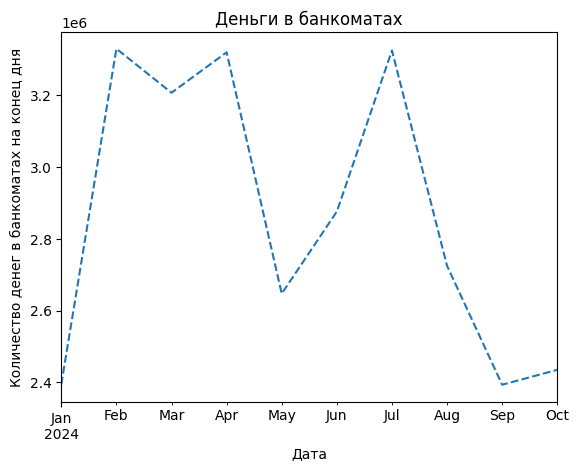

In [84]:
ax = transactions_fees.groupby(transactions_fees['date'].dt.to_period('M'))['bal_end_of_day'].mean().plot(style=['--', 'o-', 'o'])
ax.set(title='Деньги в банкоматах', 
       xlabel='Дата', 
       ylabel='Количество денег в банкоматах на конец дня')

<a id="part3_5"></a>
## Часть 3.5 - предобработка данных

[Вернуться к оглавлению](#content)

### Обработка пропущенных значений

Самый распространный варинат заполнения пропущенных значений - заполнение средним значеинем. Но я предпочитаю использовать ML алгоритмы для заполнения: KNN, регрессии/классификации. Есть еще алгоритмы MICE, но я его никогда не исопльзовал.

Так как набор данных представляет собой временной ряд, то в нем может присутствовать автокорреляция между значениями и есть смысл воспользовать одним из этих подходов:
- заполнение предыдущим значением
- заполнение последующим значением

Для конечной цели воспользуюсь первым вариантом.


In [20]:
new_transation_fees = transactions_fees

for i in range(new_transation_fees.shape[1]):
    new_transation_fees.iloc[:, i].fillna(method='bfill', inplace=True)

/tmp/ipykernel_421/389650964.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  new_transation_fees.iloc[:, i].fillna(method='bfill', inplace=True)
/tmp/ipykernel_421/389650964.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  new_transation_fees.iloc[:, i].fillna(method='bfill', inplace=True)


In [21]:
check_nan(new_transation_fees)

Counts NaN on date: 0 of 1176
Counts NaN on ATM_ID: 0 of 1176
Counts NaN on bal_end_of_day: 0 of 1176
Counts NaN on cash_in: 0 of 1176
Counts NaN on cash_out: 0 of 1176
Counts NaN on rate: 0 of 1176
Counts NaN on CashDeliveryFixedFee: 0 of 1176
Counts NaN on CashDeliveryPercentageFee: 0 of 1176
Counts NaN on CashDeliveryMinFee: 0 of 1176
Counts NaN on CashCollectionFixedFee: 0 of 1176
Counts NaN on CashCollectionPercentageFee: 0 of 1176
Counts NaN on CashCollectionMinFee: 0 of 1176


In [22]:
new_transation_fees.to_csv('final_dataset1.csv')

### Проверяка ряда на стационарность

Важно выяснить является ли ряд стационарным или нет, так как от этого зависит ряд применяемых инструментов. Согласно нулевой гипотезе предполагается, что временной ряд нестационарный. 

In [32]:
result = adfuller(new_transation_fees['bal_end_of_day'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print('Critical values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.655476207296036
p-value: 4.9969298967930795e-09
Critical values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


По p-value видно, что нулевая гипотеза неверна, а это значит, что ряд стационарен.

<a id="part4"></a>
## Часть 4 - меняем бизнес с помощью ML

[Вернуться к оглавлению](#content)

Заключительная и самая интересная часть. К данному этапу у нас уже рассчитан упущенный процентный доход и расходы на инкассацию. Подумайте, как использовать ваши знания, чтобы оптимизировать процесс инкассации и уменьшить издержки.

Для данной задачи считаем, что нас устроит Service Level на уровне 90%. Это значит, что если в 9 из 10 случаев наши клиенты получают нужные им суммы, нас это устраивает.

Напоминаем, что технически в банкомат нельзя довнести сумму, и кассета меняется полностью. Соответственно, с нас берут оплату за полную кассету (если вдруг решите подойти к задаче через классическую формулу EOQ).

Вы можете подойти к задаче абсолютно любым способом и использовать все возможности ООП, Python и любых библиотек. Всё как в реальной работе, где вас никто не ограничивает.

Эффективность своего решения вы можете показать с помощью ретротестирования. Считаем, что каждая кассета может вмещать абсолютно любые суммы. Чтобы добавить реализма, вы можете считать, что деньги нужно заказывать за 3 дня до их доставки.


#### Более формальная постановка задачи

В данных есть временной ряд, поэтому можно попробовать исопльзовать такие подходы, как Prophet, ARIMA, SARIMA, нейросети(в частности архитектура LSTM).

По факту, нам нужно минимизировать издрежки на инкассацию и обеспечить вероятность полного опустошения банкомата < 10%. 

В задаче ML можно выделить 2 подхода:
- решать задачу регресси, когда мы пытаемся предсказать баланс на такой-то промежуток времени, например, следующий день.
- задачу классификации, когда мы пытаемся предсказать момент, для проведения инкассации.

### Модель ARIMA

### Заключение

Решение вы можете предоставить любым способом: репозиторий GitHub, Google Colab, конвертированный IPython Notebook в PDF и т. п.

По срокам вас не ограничивают, но учитывайте, что в это же время задачу могут решать и другие кандидаты. Таким образом, вы участвуете в конкурсе с ними.